In [1]:
import numpy as np
import numba
from matplotlib import pyplot as plt

In [117]:
@numba.njit
def mean(individual1, individual2):
        return (individual1+individual2)/2.0
    
@numba.njit
def one_point(individual1, individual2):
    index = np.random.randint(individual1.shape[0])

    new_individual = np.empty_like(individual1)
    new_individual[:index] = individual1[:index]
    new_individual[index:] = individual2[index:]

    return new_individual

class AG:

        
    def __init__(self, population_size, mutation_rate, mutation_range, mutation_patience=10, cross_over = mean, dtype=np.float32):
        #Colocar opção default que mutation_rate=1
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.mutation_range = mutation_range
        self.mutation_patience = mutation_patience
        self.dtype = dtype
        self.cross_over = cross_over

    def mutation(self, individual):
        #Alterar para poder mutacionar apenas um gene
        if np.random.rand() < self.mutation_rate:
            individual += (2.0*(np.random.rand(self.chromosome_size)-0.5))*self.mutation_range
        
        return individual

        
    

    def selection(self): #tournament
        index1 = np.random.randint(self.population_size)
        index2 = np.random.randint(self.population_size)

        if self.fitness_scores[index1] > self.fitness_scores[index2]:
            return self.population[index1]
        return self.population[index2]

    def new_population(self):
        new_population = np.zeros_like(self.population)
        
        best_fitness = np.argmax(self.fitness_scores)
        best_individual = self.population[best_fitness]

        self.individual_best_hist[self.current_generation] = best_individual
        self.fitness_best_hist[self.current_generation] = self.fitness_scores[best_fitness]
        self.fitness_mean_hist[self.current_generation] = np.mean(self.fitness_scores)
        self.fitness_std_hist[self.current_generation] = np.std(self.fitness_scores)


        new_population[0] = best_individual

        for i in range(1, self.population_size):
            father1 = self.selection()
            father2 = self.selection()

            new_individual = self.cross_over(father1, father2)
            new_individual = self.mutation(new_individual)

            new_population[i] = new_individual
        
        return new_population
        
    
    def optimize(self, fitness_function, chromosome_size, max_cromossome_value, min_cromossome_value, n_generation):
        self.chromosome_size = chromosome_size

        self.stopped_count = 0

        self.population = np.random.rand(self.population_size, self.chromosome_size).astype(self.dtype)
        self.population *= max_cromossome_value-min_cromossome_value
        self.population += min_cromossome_value

        self.fitness_scores = np.zeros(self.population_size)

        self.individual_best_hist = np.zeros((n_generation, chromosome_size))
        self.fitness_best_hist = np.zeros(n_generation)
        self.fitness_mean_hist = np.zeros(n_generation)
        self.fitness_std_hist = np.zeros(n_generation)

        self.current_generation = 0

        for i in range(n_generation):
            for j in range(self.population_size):
                self.fitness_scores[j] = fitness_function(self.population[j])

            self.population = self.new_population()

            if i > 0:
                if(abs(self.fitness_best_hist[i] - self.fitness_best_hist[i-1]) < 1E-4):
                    self.stopped_count += 1
                else:
                    self.stopped_count = 0
            
            if self.stopped_count > self.mutation_patience:
                self.mutation_range *= 2.0
                self.mutation_rate *= 2.0
                self.stopped_count = 0

            self.current_generation += 1
    
    def plot_fitness(self, max_value = None, min_value = None):
        plt.plot(np.arange(self.current_generation), self.fitness_best_hist)
        plt.plot(np.arange(self.current_generation), self.fitness_mean_hist)
        
        plt.legend(["Best individual", "Mean"])
        plt.xlabel("Generation")
        plt.ylabel("Fitness")

        if max_value is None:
            max_value = self.fitness_best_hist[-1] + (self.fitness_best_hist[-1]/2.0)

        plt.ylim(bottom = min_value, top=max_value)
        
        plt.show()
    
    def plot_individual(self):
        plt.title("Best individuals")

        for i in range(self.chromosome_size):
            plt.plot(np.arange(self.current_generation), self.individual_best_hist[: , i], label="x"+str(i))

        plt.legend()
        plt.xlabel("Generation")
        plt.ylabel("Gene")

        plt.show()
    
    def plot_gene(self):
        fig, ax = plt.subplots(self.chromosome_size, 2, figsize=(10,10))

        for i in range(self.chromosome_size):
            ax[i][0].set_title("x"+str(i))
            ax[i][0].plot(np.arange(self.current_generation), self.individual_best_hist[: , i])
            ax[i][0].legend(["x"+str(i)])
            #ax[i][0].set_xlabel("Generation")

            ax[i][1].set_title("x"+str(i)+" - last generations")
            ax[i][1].plot(np.arange(self.current_generation)[50:], self.individual_best_hist[self.current_generation//2: , i])
            ax[i][1].legend(["x"+str(i)])

        plt.show()





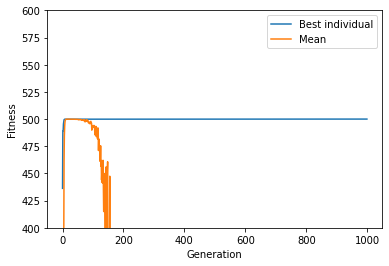

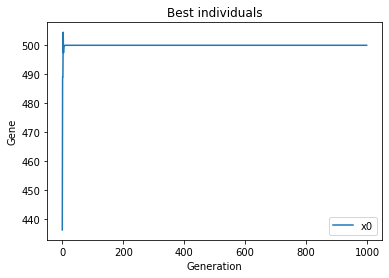

In [112]:
@numba.njit
def fitness_function(individual):

    if individual[0] > 500:
        return 1000-individual
    return individual

ag = AG(100, 0.1, 1)

ag.optimize(fitness_function, 1, 10000, -10000, 1000)

ag.plot_fitness(min_value = 400, max_value = 600)
ag.plot_individual()

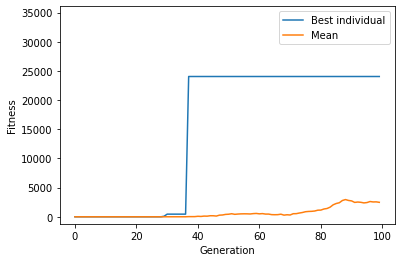

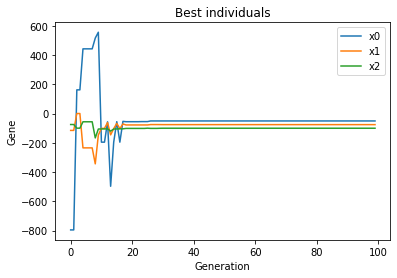

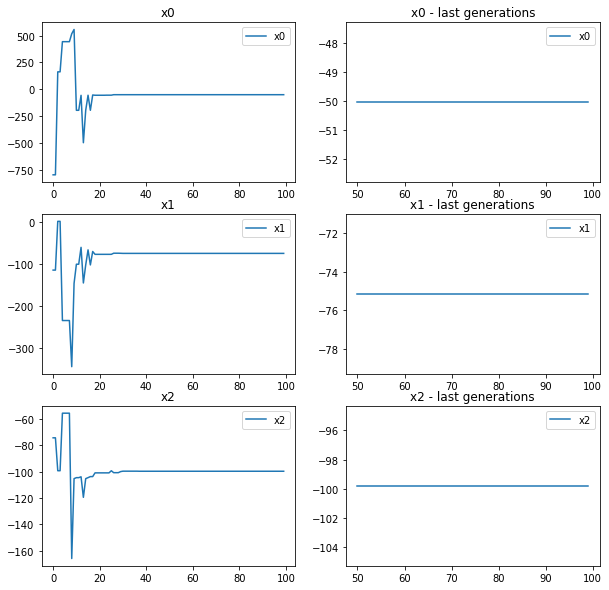

array([-50.04573822, -75.15137482, -99.80593872])

In [113]:
@numba.njit
def fitness_function2(individual):
    score = np.power(individual[0]+50, 2)
    score += np.power(individual[1]+75, 3)
    score += np.power(individual[2]+100, 4) 

    return 1/score


ag = AG(1000, 0.1, 2, cross_over=one_point)

n_generation = 100
ag.optimize(fitness_function2, 3, 1000, -1000, n_generation)

ag.plot_fitness()
ag.plot_individual()
ag.plot_gene()

ag.individual_best_hist[-1]

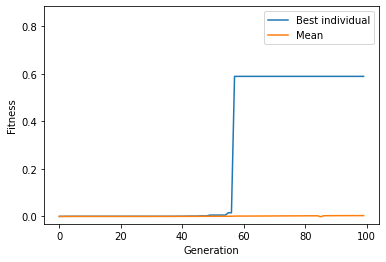

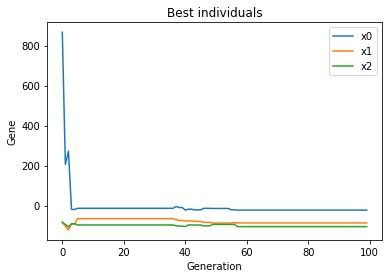

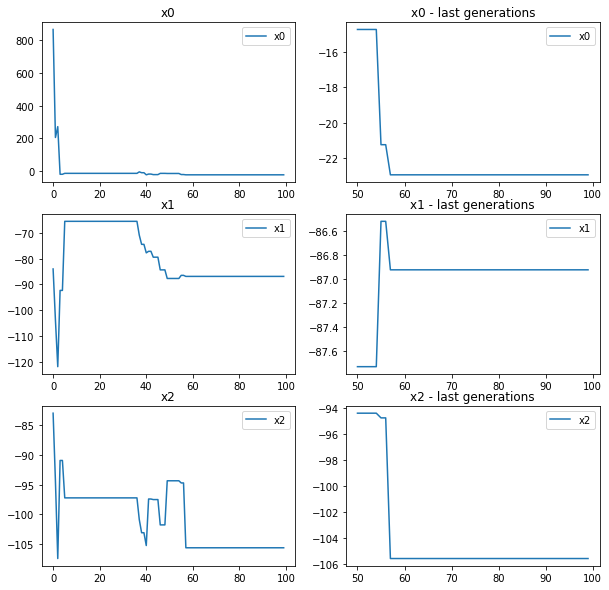

array([ -22.95405388,  -86.92330933, -105.57397461])

In [114]:
ag = AG(1000, 0.1, 2, cross_over=mean)

n_generation = 100
ag.optimize(fitness_function2, 3, 1000, -1000, n_generation)

ag.plot_fitness()
ag.plot_individual()
ag.plot_gene()

ag.individual_best_hist[-1]

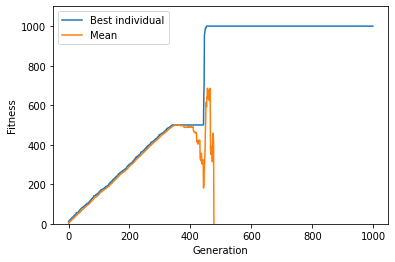

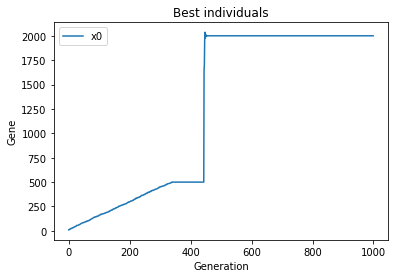

In [122]:
@numba.njit
def fitness_function3(individual):

    if individual[0] < 500:
        return individual
    elif individual[0] < 1000:
        return 1000 - individual
    elif individual[0] < 2000:
        return individual - 1000
    else:
        return 3000 - individual


ag = AG(100, 0.1, 10)

ag.optimize(fitness_function3, 1, 10, -10, 1000)

ag.plot_fitness(min_value = 0, max_value = 1100)
ag.plot_individual()